In [1]:
#Future imports.
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

In [88]:
#Other imports.
import pandas as pd
import numpy as np

import stop_words
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import PorterStemmer

import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

import time      

import pickle

In [3]:
#Define the timeit decorator.                                          
def timeit(method):
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()
        if 'log_time' in kw:
            name = kw.get('log_name', method.__name__.upper())
            kw['log_time'][name] = int((te - ts) * 1000)
        else:
            print('%r  %2.2f ms' % \
                  (method.__name__, (te - ts) * 1000))
        return result
    return timed

In [4]:
#Define pickling functions.
def pickle_dump(data, filename):
    with open(filename, 'wb') as f:
        pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)
    
def pickle_load(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [5]:
#Gets data and stores it as a dataframe.
def fetch():
    train_haptik = pd.read_csv('./data/domain_classification/train_data.csv', encoding='UTF-8')
    test_haptik = pd.read_csv('./data/domain_classification/test_data.csv', encoding='UTF-8')
    return train_haptik, test_haptik

In [6]:
#Separates feature and target variables.
def feature_target_separator(df):
    feature = df.iloc[:,0]
    target = df.iloc[:,1:]
    return feature, target

In [7]:
#Reverse OHE
@timeit
def reverse_ohe(df):
    for column in df.columns:
        df[column] = df[column].astype(str).map({'F':0, 'T':1})
    return df


In [8]:
#Will replace rows with multiple labels with only the first label.
def replace_multi_label(df):
    df = df.idxmax(1)
    return df

In [9]:
#Perform pre-processing(Tokenize, remove stop words and stem)
@timeit
def preprocess(input_ls, stem=False):
    tokenizer_obj= TreebankWordTokenizer()
    ps = PorterStemmer()
    input_ls = [x.lower() for x in input_ls]
    tokens = [tokenizer_obj.tokenize(x) for x in input_ls]
    stopwords = stop_words.get_stop_words('english')
    stopwords.extend(['{','}', 'task_name', 'api_name', 'product_id',
                      "n't", 'thank','hey','please','hello','user_id',
                      'plz','a9c0', 'f0af5ee2b89b', '676951', 'hi', '727893', '55616'])
    input_ls = [list(set(x).difference(set(stopwords))) for x in tokens]
    if stem:
        input_ls = [map(ps.stem,x) for x in input_ls]
    return input_ls
    

In [10]:
#Makes a wordcloud.
@timeit
def word_cloud(list_of_tokens):
    temp_list = []
    _ = [temp_list.extend(x) for x in list_of_tokens]
    word_cloud_object = WordCloud(max_font_size=30)
    word_cloud_object.generate(' '.join(temp_list))
    plt.figure(figsize=(10,10))
    plt.imshow(word_cloud_object)
    #print(temp_list)

In [97]:
train, test = fetch()

train_feature_haptik, train_target_haptik = feature_target_separator(train)
train_target_haptik = reverse_ohe(train_target_haptik)
#train_target_haptik = replace_multi_label(train_target_haptik)

test_feature_haptik, test_target_haptik = feature_target_separator(test)
test_target_haptik = reverse_ohe(test_target_haptik)
#test_target_haptik = replace_multi_label(test_target_haptik)

/home/daksha/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


'reverse_ohe'  1124.09 ms
'reverse_ohe'  927.89 ms


In [98]:
list_of_train_tokens = preprocess(train_feature_haptik, stem=True)
list_of_test_tokens = preprocess(test_feature_haptik, stem=True)

'preprocess'  12726.57 ms
'preprocess'  2912.08 ms


'word_cloud'  2531.60 ms


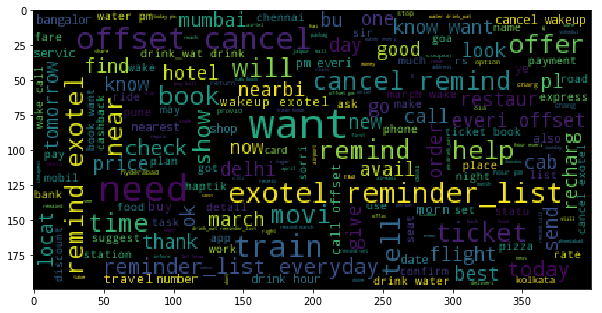

In [99]:
word_cloud(list_of_train_tokens)

'word_cloud'  1146.91 ms


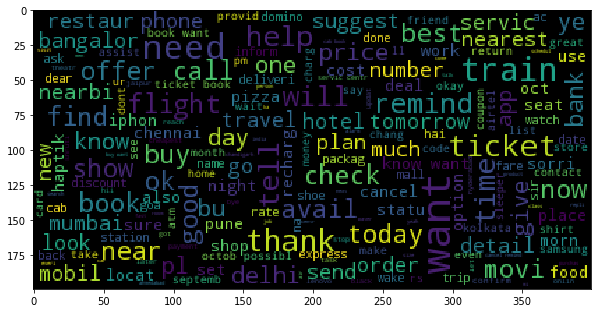

In [100]:
word_cloud(list_of_test_tokens)

In [101]:
@timeit
def createDF(message_list,category_df):
    m_series = pd.Series(message_list)
    m_series = m_series.apply(lambda x:' '.join(x))
    fin_df = pd.concat([m_series,category_df],axis=1)
    fin_df = fin_df.rename(columns={0:'message',1:'category'})
    return fin_df
    


In [102]:
train_df = createDF(list_of_train_tokens,train_target_haptik)
test_df = createDF(list_of_test_tokens,test_target_haptik)
len(train_df)

'createDF'  72.57 ms
'createDF'  18.11 ms


40659

# MultinomialNB approach.(Uses only single label.)

In [103]:
# @timeit
# def train_clf(df):
#     t = TreebankWordTokenizer()
#     sw = stop_words.get_stop_words('english')
#     df = df.sample(frac=1, replace=False)
#     X_train = df['message']
#     Y_train = df['category']
#     #lbe = LabelEncoder()
#     #Y_train = lbe.fit_transform(Y_train)
#     #vect = CountVectorizer(ngram_range=(1,2), min_df=2, max_df=0.2)
#     vect = TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.5, norm='l1')
#     X_train_dtm = vect.fit_transform(X_train)
#     clf = MultinomialNB(alpha=0.25, fit_prior=False)
#     clf.fit(X_train_dtm,Y_train)
#     #print(clf)
#     return clf,vect

# train_clf(train_df)

In [104]:
# @timeit
# def classify((clf_obj,vect),df):
#     df = df.sample(frac=1, replace=False)
#     X_test = df['message']
#     Y_test = df['category']
#     #lbe = LabelEncoder()
#     #Y_test = lbe.fit_transform(Y_test)
#     X_test_dtm = vect.transform(X_test)
#     Y_pred = clf_obj.predict(X_test_dtm)
#     print('Accuracy is: {}'.format(accuracy_score(Y_test,Y_pred)*100))
#     print(classification_report(Y_test,Y_pred))
#     print()
#     print(confusion_matrix(Y_test,Y_pred))
#     print()
#     print(cross_val_score(clf_obj,X_test_dtm,Y_test,cv=10))
#     print(cross_val_score(clf_obj,X_test_dtm,Y_test,cv=10).mean())
#     return Y_pred

In [105]:
#classify(train_clf(train_df),test_df)

# Random Forest Classifier. (Supports multiple labels)

In [106]:
#train random-forest-classifier
@timeit
def train_rf(X, Y, vect=TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.5, norm='l1'), clf=RandomForestClassifier(n_estimators=100, min_samples_split=10, random_state=50)):
    X_train = vect.fit_transform(X)
    rf_clf = clf
    rf_clf.fit(X_train, Y)
    return rf_clf, vect

In [107]:
#predict method. make sure that you pass the exact same vectorizer as you used in train.
@timeit
def pred_rf(X, Y, vect, clf):
    X_test = vect.transform(X)
    Y_pred = clf.predict(X_test)
    print('Subset accuracy is {}'.format(accuracy_score(Y, Y_pred)))
    msk = Y_pred == Y
    label_acc = msk.sum().sum()/msk.size
    print('Label accuracy is {}'.format(label_acc))
    cv = cross_val_score(clf,Y, Y_pred,cv=10)
    print(cv)
    print(cv.mean())
    #res = (Y_pred == Y)
    print(classification_report(Y, Y_pred))
    return Y_pred
    

In [108]:
train_df.columns

Index([u'message', u'food', u'recharge', u'support', u'reminders', u'travel',
       u'nearby', u'movies', u'casual', u'other'],
      dtype='object')

In [109]:
train_df = train_df.sample(frac=1)
rf_clf, vect_obj = train_rf(train_df['message'], train_df[train_df.columns[1:]],  vect=CountVectorizer(ngram_range=(1,2), min_df=2, max_df=0.5), )

'train_rf'  137683.11 ms


In [110]:
test_df = test_df.sample(frac=1)
pred_op = pred_rf(test_df['message'], test_df[test_df.columns[1:]], vect_obj, rf_clf)

Subset accuracy is 0.7277
Label accuracy is 0.947122222222
[ 0.719  0.755  0.749  0.727  0.716  0.718  0.719  0.719  0.674  0.741]
0.7237
             precision    recall  f1-score   support

          0       0.84      0.59      0.69       810
          1       0.77      0.65      0.71       450
          2       0.81      0.28      0.42       371
          3       0.87      0.84      0.85       893
          4       0.82      0.85      0.83      2138
          5       0.75      0.60      0.67       807
          6       0.79      0.57      0.67       637
          7       0.84      0.83      0.84      3282
          8       0.94      0.49      0.64      1668

avg / total       0.84      0.71      0.76     11056

'pred_rf'  21121.68 ms


# How the classifier performed on rows having multiple labels.

In [111]:
ser = test_df[test_df.columns[1:]].sum(axis=1)
msk = ser > 1
ser[msk].index

Int64Index([6995, 8046, 8509, 7061, 9149, 5861, 5417, 6135, 9613, 6598,
            ...
            7783, 7105, 8266, 5386, 6269, 8781, 9636, 5299, 8242, 9618],
           dtype='int64', length=508)

In [112]:
multi_df = test_df[test_df.index.isin(ser[msk].index)]
multi_df.drop('message', axis=1, inplace=True)

/home/daksha/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [113]:
op_df = pd.DataFrame(pred_op, columns=test_df.columns[1:], index=test_df.index)
op_multi = op_df[op_df.index.isin(ser[msk].index)]

In [114]:
print(len(op_multi), len(multi_df))

508 508


In [115]:
print(accuracy_score(multi_df, op_multi))

0.0964566929134


# Experimenting with OneVsRestClassifier

## RandomForest + OneVsRestClassifier

In [116]:
@timeit
def train_ovr(X, Y, vect=TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.5), clf=OneVsRestClassifier(RandomForestClassifier(n_estimators=50))):
    X_train = vect.fit_transform(X)
    rf_clf = clf
    rf_clf.fit(X_train, Y)
    return rf_clf, vect

In [117]:
ovr_rf_clf, ovr_rf_vect = train_ovr(train_df['message'], train_df[train_df.columns[1:]])

'train_ovr'  492955.55 ms


In [118]:
y_rf_op = pred_rf(test_df['message'], test_df[test_df.columns[1:]], ovr_rf_vect, ovr_rf_clf)

Subset accuracy is 0.7134
Label accuracy is 0.9463
[ 0.704  0.74   0.741  0.722  0.74   0.698  0.708  0.715  0.709  0.722]
0.7199
             precision    recall  f1-score   support

          0       0.80      0.65      0.71       810
          1       0.78      0.66      0.72       450
          2       0.69      0.33      0.45       371
          3       0.85      0.85      0.85       893
          4       0.81      0.86      0.84      2138
          5       0.64      0.64      0.64       807
          6       0.78      0.61      0.69       637
          7       0.84      0.80      0.82      3282
          8       0.90      0.58      0.70      1668

avg / total       0.82      0.73      0.76     11056

'pred_rf'  49603.41 ms


## SVM + OneVsRestClassifier

In [119]:
#ovr_clf, ovr_vect = train_ovr(train_df['message'], train_df[train_df.columns[1:]], clf=SVC(C=5, kernel='linear'))

In [120]:
SVM_obj = pickle_load('LinearSVM')
SVM_obj

OneVsRestClassifier(estimator=SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel=u'linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=1)

In [121]:
y_op = pred_rf(test_df['message'], test_df[test_df.columns[1:]], ovr_vect, SVM_obj)

Subset accuracy is 0.617
Label accuracy is 0.935011111111
[ 0.63   0.589  0.565  0.623  0.62   0.596  0.633  0.591  0.589  0.627]
0.6063
             precision    recall  f1-score   support

          0       0.80      0.50      0.62       810
          1       0.74      0.62      0.68       450
          2       0.67      0.19      0.29       371
          3       0.84      0.83      0.84       893
          4       0.77      0.83      0.80      2138
          5       0.64      0.57      0.60       807
          6       0.73      0.45      0.56       637
          7       0.88      0.61      0.72      3282
          8       0.91      0.49      0.64      1668

avg / total       0.81      0.62      0.69     11056

'pred_rf'  65129.44 ms


## MultinomialNB + OneVsRestClassifier

In [122]:
mnb_clf, mnb_vect = train_ovr(train_df['message'], train_df[train_df.columns[1:]], vect=CountVectorizer(ngram_range=(1,2), min_df=2, max_df=0.5), clf=OneVsRestClassifier(MultinomialNB(alpha=0.45)))

'train_ovr'  1643.21 ms


In [123]:
pred_rf(test_df['message'], test_df[test_df.columns[1:]], mnb_vect, mnb_clf)

Subset accuracy is 0.6308
Label accuracy is 0.938266666667
[ 0.63   0.655  0.642  0.627  0.658  0.63   0.628  0.62   0.644  0.63 ]
0.6364
             precision    recall  f1-score   support

          0       0.78      0.65      0.71       810
          1       0.66      0.71      0.68       450
          2       0.60      0.44      0.51       371
          3       0.90      0.80      0.85       893
          4       0.77      0.88      0.82      2138
          5       0.53      0.67      0.60       807
          6       0.74      0.61      0.67       637
          7       0.88      0.59      0.71      3282
          8       0.87      0.68      0.76      1668

avg / total       0.80      0.69      0.73     11056

'pred_rf'  1149.77 ms


array([[0, 1, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

## LogisticRegression + OneVsRestClassifier

In [124]:
lr_clf, lr_vect = train_ovr(train_df['message'], train_df[train_df.columns[1:]], vect=CountVectorizer(ngram_range=(1,2), min_df=2, max_df=0.5), clf=OneVsRestClassifier(LogisticRegression(solver='newton-cg', multi_class='multinomial')))

'train_ovr'  23751.22 ms


In [125]:
pred_rf(test_df['message'], test_df[test_df.columns[1:]], lr_vect, lr_clf)

Subset accuracy is 0.6768
Label accuracy is 0.947022222222
[ 0.679  0.701  0.686  0.69   0.714  0.669  0.679  0.68   0.708  0.683]
0.6889
             precision    recall  f1-score   support

          0       0.89      0.59      0.71       810
          1       0.82      0.61      0.70       450
          2       0.80      0.31      0.45       371
          3       0.92      0.81      0.86       893
          4       0.85      0.85      0.85      2138
          5       0.72      0.60      0.66       807
          6       0.87      0.56      0.68       637
          7       0.91      0.64      0.75      3282
          8       0.93      0.58      0.72      1668

avg / total       0.88      0.66      0.75     11056

'pred_rf'  18240.51 ms


array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

## Decision Tree + OneVsRestClassifier

In [140]:
dt_clf, dt_vect = train_ovr(train_df['message'], train_df[train_df.columns[1:]], vect=CountVectorizer(ngram_range=(1,2), min_df=2, max_df=0.5), clf=OneVsRestClassifier(DecisionTreeClassifier(min_samples_split=50, criterion='entropy')))

'train_ovr'  67820.58 ms


In [141]:
pred_rf(test_df['message'], test_df[test_df.columns[1:]], dt_vect, dt_clf)

Subset accuracy is 0.6768
Label accuracy is 0.940577777778
[ 0.658  0.712  0.71   0.686  0.717  0.664  0.67   0.674  0.679  0.699]
0.6869
             precision    recall  f1-score   support

          0       0.75      0.64      0.69       810
          1       0.67      0.69      0.68       450
          2       0.59      0.33      0.42       371
          3       0.82      0.81      0.82       893
          4       0.78      0.85      0.81      2138
          5       0.63      0.61      0.62       807
          6       0.74      0.58      0.65       637
          7       0.81      0.82      0.81      3282
          8       0.85      0.58      0.69      1668

avg / total       0.78      0.72      0.74     11056

'pred_rf'  1367.66 ms


array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]])